IN progress

input (or scrape) band members active dates (like to be down to the day of year, or at least month) and record releases
plot like wikipedia does, but interactive
    - select time frame
    - note instrument changes (bassist leaves on X day, new bassist comes in at y day, for example)
not every band has a graph, this could be an alternative

Spotify API seems best way to obtain album release dates that include month and day
    - combine with scraping for band members?

In [816]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
import matplotlib.dates as mdates
import seaborn as sns
import dotenv
# from dotenv import load_dotenv
import os
import numpy as np


### Load in Spotify API credentials here 
os.chdir('C:\\Users\\dwagn\\Desktop')
dotenv.load_dotenv()
CLIENT_ID = os.getenv('spotify-client-id')
CLIENT_SECRET = os.getenv('spotify-client-secret')
os.chdir('C:\\Users\\dwagn\\git\\projects')


### Setup 
AUTH_URL = 'https://accounts.spotify.com/api/token'

auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET
})

auth_response_data = auth_response.json()
access_token = auth_response_data['access_token']

try:
    auth_response.status_code == 200
    print('Successfully accessed API')
except:
    raise Exception('API credentials rejected.')

Successfully accessed API


In [817]:
### Uncomment below for manual entry
# artist_share_url = input('Paste artist spotify share link: ')
# artist_id = artist_share_url.split('/')[4].split('?')[0]
artist_id = '2hl0xAkS2AIRAu23TVMBG1'

headers = {'Authorization': 'Bearer {}'.format(access_token)}
url = 'https://api.spotify.com/v1/'

artist_name = requests.get(url + 'artists/' + artist_id, headers=headers).json()['name']
    
albums = requests.get(url + 'artists/' + artist_id + '/albums', 
                 headers=headers, 
                 params={'include_groups': 'album', 'limit': 50}).json()

album_names_dates = {}
for album in albums['items']:
    album_names_dates[album['name']] = album['release_date']

In [818]:
albums_df = pd.DataFrame.from_dict(album_names_dates, orient = 'index').reset_index()
albums_df.columns = ['album', 'release_date']

In [819]:
albums_df.release_date = pd.to_datetime(albums_df.release_date)
albums_df

,album,release_date
0,Nothing To Lose (Live 1984),2021-11-03
1,Point Of Know Return Live & Beyond,2021-05-28
2,Talk To The Wind (Live In Chicago '76),2020-12-04
3,Beyond The Illusion (The 1980 New York Broadca...,2020-07-31
4,The Absence Of Presence,2020-07-17
5,The Absence of Presence,2020-07-17
6,Wheels and Other Rarities,2018-11-30
7,Leftoverture Live & Beyond,2017-11-03
8,The Prelude Implicit,2016-09-23
9,The Prelude Implicit (Deluxe Edition),2016-09-23


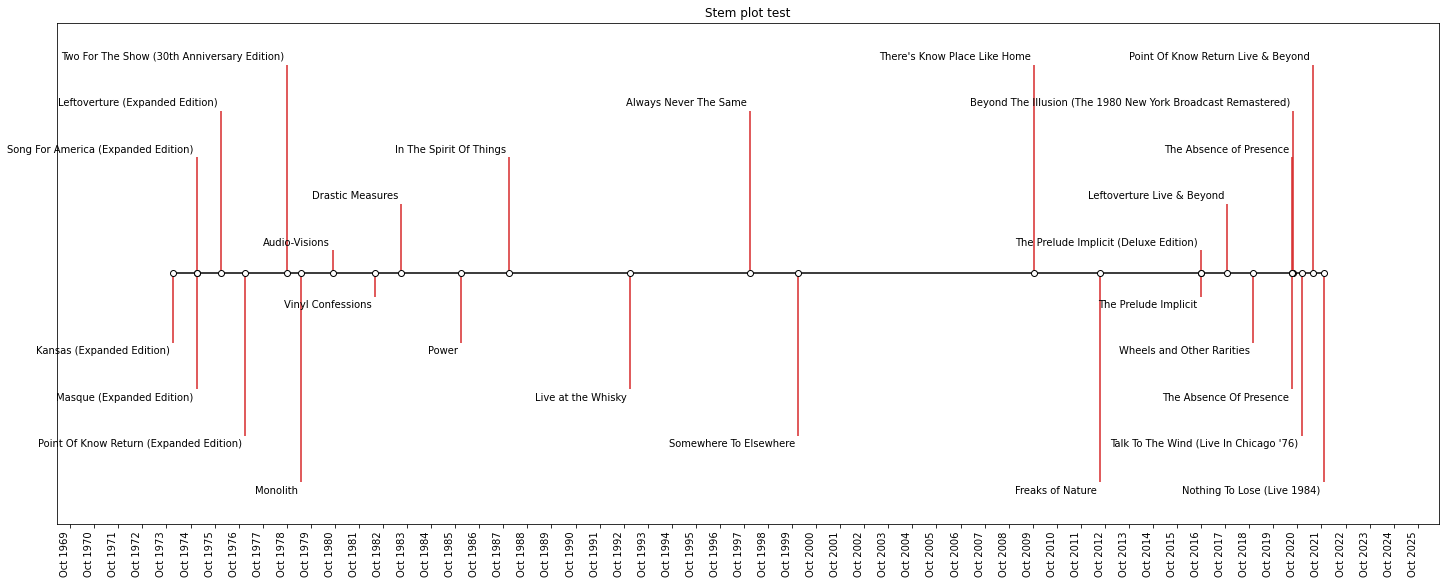

In [820]:
# stem([locs,] heads, linefmt=None, markerfmt=None, basefmt=None)
dates = albums_df.release_date
names = albums_df.album
levels = np.tile([-9, 9, -7, 7, -5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

fig, ax = plt.subplots(figsize=(20, 8), constrained_layout=True)
ax.set(title='Stem plot test')
ax.vlines(dates, 0, levels, color='tab:red')
ax.plot(dates, np.zeros_like(dates), '-o',
        color='k', markerfacecolor='w')

for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top")
    
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12)) # by year
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=90, ha="right"); # semicolon stopping label output

ax.margins(y=0.1, x=0.1)
ax.get_yaxis().set_visible(False)
plt.show()

In [823]:
# Scrape Wikipedia Band Members Dates

import requests
import csv
from bs4 import BeautifulSoup
import datetime


headers = {'user-agent': 'Contact: dbw2tn@virginia.edu (Language=Python 3.8.2; Platform=Linux(MX-19.4 / 31))'} 

url_band_name = 'Kansas_(band)'
url = 'https://en.wikipedia.org/wiki/{}'.format(url_band_name)
result = requests.get(url, headers = headers)


try:
    result.status_code == 200
    print('Successfully accessed {} webpage'.format(url_band_name))
except:
    raise Exception('Error accessing {} webpage'.format(url_band_name))

src = result.content 
soup = BeautifulSoup(src, 'html.parser') 

Successfully accessed Kansas_(band) webpage


In [827]:
members_link = soup.find(text=lambda s: "main article:" in s.lower()) \
              .findNextSibling('a', href=True).get('href') # get link for full members page
members_link

'/wiki/List_of_Kansas_band_members'

In [838]:
mems = soup.find(id='Members')
mems.next_sibling()

[<span class="mw-editsection-bracket">[</span>,
 <a href="/w/index.php?title=Kansas_(band)&amp;action=edit&amp;section=13" title="Edit section: Members">edit</a>,
 <span class="mw-editsection-bracket">]</span>]

In [833]:
try:
    current_members = soup.find(text=lambda s: "current members" in s.lower()) \
                  .findNext('ul').get_text().split('\n')
    print('Found current members')
except:
    print('No current members listed')

Found current members


In [834]:
try:
    former_members_main_page = soup.find(text = lambda s: 'former members' in s.lower()) \
                           .findNext('ul').get_text().split('\n')
    print('Found former members')
except:
    print('No former members listed on this page')

No former members listed on this page


In [835]:
split_names = [mem.split(' – ') for mem in current_members]
split_names = [item for sublist in split_names for item in sublist] # back to single list
split_dates = [d.split('(') for d in split_names[1::2]]
split_dates = [item for sublist in split_dates for item in sublist]
instr = split_dates[::2]
dates = split_dates[1::2]
names = split_names[::2]

In [836]:
pd.DataFrame({'names' : names,
             'instruments' : instr,
             'dates' : dates})

,names,instruments,dates
0,Phil Ehart,"drums, percussion","1970-1971, 1973–1984, 1985–present)"
1,Rich Williams,lead and rhythm guitars,"1973–1984, 1985–present)"
2,Billy Greer,"bass, acoustic guitar, backing and lead vocals",1985–present)
3,David Ragsdale,"violin, rhythm guitar, backing vocals","1991–1997, 2006–present)"
4,Ronnie Platt,"lead and backing vocals, keyboards",2014–present)
5,Tom Brislin,"keyboards, backing and lead vocals",2018–present)


In [839]:
# If applicable, get link to full members page
if 'members' not in str(soup.find(id="toc").get_text().lower()):
    print('Warning: Band Members section not found on this page')
if all(x in soup.get_text() for x in ['Main article: List of', 'band members']):
    members_link = soup.find(text=lambda s: "main article:" in s.lower()) \
                  .findNextSibling('a', href=True).get('href') # get link for full members
    print('Full members in link: {}'.format(members_link))

Full members in link: /wiki/List_of_Kansas_band_members


In [840]:
url = 'https://en.wikipedia.org{}'.format(members_link)
result = requests.get(url, headers = headers)

try:
    result.status_code == 200
    print('Successfully accessed {} webpage'.format(members_link))
except:
    raise Exception('Error accessing {} webpage'.format(members_link))

src = result.content 
member_soup = BeautifulSoup(src, 'html.parser') 

Successfully accessed /wiki/List_of_Kansas_band_members webpage


In [844]:
names, dts, inst, act = [], [], [], [] # init lists before function
def memsTableScrape(table, activity):
    
    for row in table.find_all('tr')[1:]:
        name = row.find_all('td')[1].get_text()
        dates = row.find_all('td')[2]
        instruments = row.find_all('td')[3]
        
        try:
            dts2 = []
            for i in dates.find('ul'):
                dts2.append(i.get_text())
        except:
            pass
        try:
            inst2 = []
            for i in instruments.find('ul'):
                inst2.append(i.get_text())
        except:
            pass
        
        names.append(name)
        if len(dts2) > 0:
            dts.append(dts2)
        else:
            dts.append(dates.get_text())
        if len(inst2) > 0:
            inst.append(inst2)
        else:
            inst.append(instruments)
        act.append(activity)


In [845]:
tbl1 = member_soup.find('table', attrs={'class' : 'wikitable'}) # current members
tbl1_title = tbl1.previous_sibling.previous_sibling.get_text().strip('[edit]')
memsTableScrape(tbl1, 'current')

In [846]:
inst
# dts

[['drums', 'percussion'],
 ['guitars (lead 1984, 1989–90, 1991–99, 2000-2016, 2021-present, rhythm otherwise)',
  'backing vocals'],
 ['bass',
  'acoustic guitar',
  'lead and backing vocals (backing until 2006, co-lead since)'],
 ['violin',
  'backing vocals (rhythm guitar from 1992-1997, 2006-2016, 2021-present)'],
 ['lead and backing vocals', 'keyboards'],
 ['keyboards', 'backing vocals']]

In [1007]:
try:
    tbl2 = tbl1.findNext('table', attrs={'class' : 'wikitable'}) # former members
    tbl2_title = tbl2.previous_sibling.previous_sibling.get_text().strip('[edit]')
    memsTableScrape(tbl2, 'former')
    
except:
    print('No second table')

In [1008]:
df_memspage = pd.DataFrame({'names' : names,
              'dates' : dts,
              'instruments' : inst})

df_memspage['names'] = df_memspage['names'].map(lambda x: x.rstrip('\n'))
# df_memspage['instruments'] = df_memspage['instruments'].map(lambda x: x.strip('\n'))
df_memspage['activity'] = act

In [1009]:
type(df_memspage.dates[0])

list

In [1012]:
# df_memspage = df_memspage.style.set_properties(subset=['instruments'], **{'width': '300px'})

# Cast lists to strings
for col in df_memspage[['dates', 'instruments']]:
    = df_memspage.dates.apply(lambda row: ', '.join(row) if type(row) is list else row)


In [1013]:
df_memspage

,names,dates,instruments,activity
0,Phil Ehart,"1970–1971, 1973–1984, 1985–present","[drums, percussion]",current
1,Rich Williams,"1973–1984, 1985–present","[guitars (lead 1984, 1989–90, 1991–99, 2000-20...",current
2,Billy Greer,1985–present\n,"[bass, acoustic guitar, lead and backing vocal...",current
3,David Ragsdale,"1991–1997, 2006–present","[violin, backing vocals (rhythm guitar from 19...",current
4,Ronnie Platt,2014–present\n,"[lead and backing vocals, keyboards]",current
...,...,...,...,...
86,John Elefante,1981–1984\n,"[lead and backing vocals, keyboards, synthesiz...",former
87,Steve Morse,"1985–1989, 1991","[lead and rhythm guitars, backing vocals]",former
88,Greg Robert,1987–1997\n,"[keyboards, backing vocals]",former
89,David Manion,2014–2018\n,"[keyboards, backing vocals]",former


In [754]:
### Retired function, after scraping into lists directly

# def formatDates(row):
#     dl = df_memspage['dates'][row]
#     if '–' in dl:
#         dl = dl.split('–')
#     elif '-' in dl:
#         dl = dl.split('-')
#     print(dl)
#     date_list = []
#     date_list.append(dl[0]) # add first date
#     if len(dl) > 2:
#         for d in dl[1:-1]:
#         # splits the middle dates in half. Assumes each is even number of ints
#             h1 = d[:len(d)//2]
#             h2 = i[len(d)//2:]
#             date_list.append(h1)
#             date_list.append(h2)
#     date_list.append(dl[-1]) # add last date
#     zipped_dl = list(zip(date_list[0::2], date_list[1::2])) # pairs 
#     df_memspage['dates'][row] = zipped_dl
#     return zipped_dl

In [755]:
# b[1:-1][0][0:4]
# b[1:-1][0][4:8]